<img src='img/banner.png' align='right' width='100%'></img>

<div class="alert alert-block alert-success">
<b>PREREQUISITE </b><br>
    
For a smooth experience, some actions are needed:

* It is expected for the user to be familiar with Python.
* The LSA SAF MDSSFTD product for the dates April 1,  2024, to April 10,  2024, in `NetCDF4` format needs to be downloaded from the [LSA SAF Data Server](https://datalsasaf.lsasvcs.ipma.pt/PRODUCTS/MSG/MDSSFTD/).
* The land/water mask file in `NetCDF4` format needs to be downloaded from the [LSA SAF Data Server](https://nextcloud.lsasvcs.ipma.pt/s/jgqdHFd5ARKjogp).

</div>

<hr>

# Calculating the Average MDSSFTD Values in the Different Sky Conditions for the First Decade of April 2024

#### About

The LSA SAF Total and Diffuse Downward Surface Shortwave Flux ([MDSSFTD](https://lsa-saf.eumetsat.int/en/data/products/radiation/#DSSF)) product provides estimates for the total (direct and diffuse) Downward Solar Shortwave radiation Flux (DSSF) as well as the fraction of diffuse radiation on wavelengths between 0.3 µm and 4.0 µm.

Downward solar radiation flux is important in climate studies, as well as in agriculture and especially important in the energy sector. MDSSFTD product values depend on the relative position of Earth with respect to the Sun, the geographical position on the Earth, atmosphere content (aerosols, gases) and current weather conditions (cloudiness).

In this Jupyter Notebook (JN) we will demonstrate how to use the MDSSFTD product to plot solar resource maps. This JN aims to calculate and plot the average total and a fraction of the diffuse downward shortwave flux from LSA SAF MDSSFTD product over Europe during the first decade of April 2024.

Additionally, the cloud conditions over the observed area will be investigated to demonstrate, how MDSSFTD product values depend on cloud conditions.

The majority of work will be done by a high-level `Python` library `xarray` which is convenient for work with multidimensional labeled data and thus allows manipulation and visualization of data with minimal code.

#### Basic Facts on LSA SAF MDSSFTD Product
> **Product number**: LSA-207
>
> **Spatial resolution**: 3 km at nadir
> 
> **Spatial coverage**: MSG-disk
> 
> **Time steps**: 15 min
> 
> **Data availability**: From 2004
> 


#### How to Access the Data

For this example, MDSSFTD estimations for the period from April 1,  2024, to April 10,  2024. All measurements are available as `NetCDF4` as well as `HDF5` files, but only the former will be used here. The LSA SAF products files can be downloaded from the [data server](https://datalsasaf.lsasvcs.ipma.pt/PRODUCTS/) available at https://datalsasaf.lsasvcs.ipma.pt/ with prior registration. The land/water mask used with LSA SAF products is also needed. It is available [here](https://nextcloud.lsasvcs.ipma.pt/s/jgqdHFd5ARKjogp).

Data can be downloaded in various ways, for instance manually, using approach published on [lsasaf_data_access GitLab](https://gitlab.com/helpdesk.landsaf/lsasaf_data_access/-/blob/main/examples/webdav/webdav_colab_example.ipynb) repository or using [WebDAV protocol](https://gitlab.com/helpdesk.landsaf/lsasaf_data_access/-/wikis/data/webdav). An additional option is to use the `GNU Wget` program. All these options are also described in the [video tutorial](https://lsa-saf.eumetsat.int/en/user-support/tutorials/).

#### Module Outline:

* [1 - Open Multifile Dataset](#First)
* [2 - Estimating the Average Total Downward Surface Short-Wave Radiation Flux](#Second)
* [3 - Estimating the Average Fraction of the Diffuse Downward Surface Short-Wave Radiation Flux](#Third)
* [4 - Determining the Sky Conditions from the LSA SAF MDSSFTD Product Quality Flag](#Fourth)

<hr>

#### Load Required Libraries

In [1]:
import matplotlib.pyplot as plt                     # a library for creating plots and visualizations
import xarray as xr                                 # a library for  handling labeled, multi-dimensional datasetst (NetCDF4 files) 
import numpy as np                                  # a library that supports numerical calculations with multidimensional arrays
import cartopy.crs as ccrs                          # a library that supports mapping and projections for plotting
import cartopy.feature as cf                        # a cartopy extension that support adding features, e.g. coastlines, borders ...
import datetime as dt

# Set the matplotlib backend to inline
%matplotlib inline

# Set the default figure size
plt.rcParams['figure.figsize'] = [13, 8]

#### Define Utility Functions

In this section, we will define the `plot_data()` function, that is used to plot 2D `xarray` datasets. It is based on the `xarray` plotting functionality. This function plots the data and adds country borders and coastlines to the plot using `cartopy` features. Since we will create multiple plots in the same manner, we will take advantage of the `plot_data()` function, rather than plot each dataset from scratch.

In [2]:
def plot_data(dataset, title=None, cmap_label=None, cmap="jet"):
    """
    A function, that plots the 2D xr dataset in PlatCarree projection.
    Inputs:
        -dataset (xr.DataSet): 2D field of data to be plotted
        -title (str): subplot title
        -cmap_label (str): Label of the colormap
        -cmap (str): Colormap to be used, default "jet" 
    """

    # Set fig, axes
    fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()}, figsize=(14, 6))

    # Plot the data
    img = dataset.plot.pcolormesh(ax=ax, transform=ccrs.PlateCarree(),
                           cmap=cmap, add_colorbar=False)

    # Add coastlines and gridlines
    ax.coastlines()
    ax.add_feature(cf.BORDERS)
    ax.gridlines(draw_labels=True, linestyle="--", color="gray", alpha=0.5)

    # Add colorbar
    cbar = plt.colorbar(img, ax=ax, orientation="vertical", pad=0.12, label=cmap_label)

    # Add title
    plt.title(title)

    return True

# <a id='First'></a>1. Open Multifile Dataset

This JN focuses on the demonstration of the use of the `xarray` library, which is especially useful for working with `NetCDF4` files.

MDSSFTD data are available on the LSA SAF Data Server as a collection of `NetCDF4` files, each consisting of a single 2D field of data (snapshot) estimated at a particular time. Estimates are available every 15 min. This is convenient for downloading since it allows the size of a single file to be reasonably small, but on the other hand poses a problem, when data from a longer period needs to be analysed.

This can be easily solved by using a multi-file dataset in `xarray`. The basic object in `xarray` is the `DataSet`, which consists of a multi-dimensional array of labeled data. We can load the `NetCDF4` file as a one dataset as described [here](https://docs.xarray.dev/en/stable/generated/xarray.open_dataset.html). We can step up this approach by opening a multifile dataset i.e. open multiple `NetCDF4` files as a single `DataSet` using `xarray.open_mfdataset()`. This functionality automatically merges multiple tables along the specified dimension. In our case, we will combine data by coordinates.

We can input a list of all files, that we want to open, or as in this case just specify the path to the directory with our data. We can specify all `NetCDF4` files in the directory using `*.nc`. Bear in mind, that in such case the directory should only consist of the `NetCDF4` files of interest (MDSSFTD product data from April 1, 2024, to April 10, 2024) and no other `NetCDF4` files. A detailed description of how to use `xarray.open_mfdataset()` is available [here](https://docs.xarray.dev/en/stable/generated/xarray.open_mfdataset.html).

In [3]:
# print multifile dataset
mdssft_ds = xr.open_mfdataset("./Data/*.nc", combine="by_coords")

# Investigate the resulting dataset
print(mdssft_ds)

<xarray.Dataset> Size: 236GB
Dimensions:           (time: 958, lat: 3201, lon: 3201)
Coordinates:
  * lat               (lat) float32 13kB 80.0 79.95 79.9 ... -79.9 -79.95 -80.0
  * lon               (lon) float32 13kB -80.0 -79.95 -79.9 ... 79.9 79.95 80.0
  * time              (time) datetime64[ns] 8kB 2024-04-01 ... 2024-04-10T23:...
Data variables:
    DSSF_TOT          (time, lat, lon) float64 79GB dask.array<chunksize=(1, 100, 100), meta=np.ndarray>
    FRACTION_DIFFUSE  (time, lat, lon) float64 79GB dask.array<chunksize=(1, 100, 100), meta=np.ndarray>
    crs               (time) |S1 958B b'' b'' b'' b'' b'' ... b'' b'' b'' b''
    quality_flag      (time, lat, lon) float64 79GB dask.array<chunksize=(1, 100, 100), meta=np.ndarray>
Attributes: (12/27)
    date_created:               2024-04-01T00:18:22Z
    algorithm_version:          2.0.0
    base_algorithm_version:     v1.0.1
    processing_level:           03
    platform:                   MSG3
    sensor:                   

Since we will investigate the average time with particular cloud conditions per day at the end of this JN, we want to determine what is the duration of our period of interest in days. We do that by estimating the time difference between the first and the last entry in our multifile dataset. Since every entry corresponds to 15 minute long time interval and not a point in the time dimension, we also need to add the 15 minutes to the time difference between the first and the last entry in the dataset.

This step is particularly important if the reader wishes to change this JN to other needs and include data from a different time interval that we are covering here.

In [4]:
# Determine first and last time entry
first_time = mdssft_ds["time"].isel(time=0)
last_time = mdssft_ds["time"].isel(time=-1)

# Calculate the timedelta between these two time points
timedelta = (last_time - first_time) +np.timedelta64(15, "m")

# Convert the timedelta to days
timedelta_days = timedelta / np.timedelta64(1, "D")

# Print time delta
print(timedelta_days)

<xarray.DataArray 'time' ()> Size: 8B
array(10.)


The data is available on the whole MSG-Disk, an area visible by the Meteosat Second Generation (MSG) geostationary satellite. Since we want to show only a smaller subset of the data we need to slice our dataset. This can be achieved using the `.sel()` method in `xarray`, which is more in detail described [here](https://docs.xarray.dev/en/latest/generated/xarray.DataArray.sel.html).

In [5]:
# Define the area of the interest
lat=slice(56, 35)
lon=slice(-10, 25)

# Slice only the are of the interest
mdssft_ds = mdssft_ds.sel(lat=lat, lon=lon)

# <a id='Second'></a>2. Estimating the Average Total Downward Surface Short-Wave Radiation Flux

Firstly, we want to calculate the average DSSF (direct + diffuse) during the first decade of April 2024. This means that we need to average all data over the time dimension and thus reduce our original 3D dataset to a 2D dataset.

The `xarray` library has the function that calculates mean value over a particular dimension already included as `xarray.mean()`, which is more in-depth described [here](https://docs.xarray.dev/en/stable/generated/xarray.DataArray.mean.html). Bear in mind, that `xarray` uses lazy loading, therefore the data is imported (and calculations are made) only when it is actually used. Therefore, the calculations of the average will be actually made when we run the next cell to output the results (make a plot).

In [6]:
# Calculate the average value
average_dssf_tot_ds = mdssft_ds.DSSF_TOT.mean(dim="time")

# Check the output dataset
print(average_dssf_tot_ds)

<xarray.DataArray 'DSSF_TOT' (lat: 421, lon: 701)> Size: 2MB
dask.array<mean_agg-aggregate, shape=(421, 701), dtype=float64, chunksize=(100, 100), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 2kB 56.0 55.95 55.9 55.85 ... 35.15 35.1 35.05 35.0
  * lon      (lon) float32 3kB -10.0 -9.95 -9.9 -9.85 ... 24.85 24.9 24.95 25.0


The simplest way to plot the data would be the `xarray` built-in plot functionality `dataset.plot()`. In our case, we will rather use the `plot_data()` function, defined at the beginning of this JN. In the next code cell, we will call the `plot_data()` function and pass our dataset, title, colormap label and chosen colormap as arguments.

True

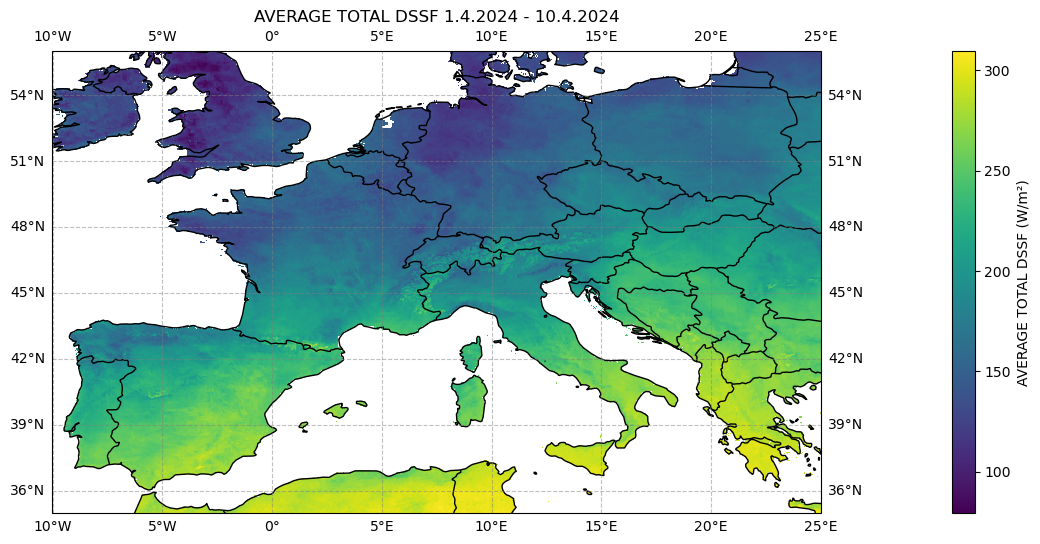

In [7]:
plot_data(
    average_dssf_tot_ds,
    title="AVERAGE TOTAL DSSF 1.4.2024 - 10.4.2024",
    cmap_label="AVERAGE TOTAL DSSF (W/m²)",
    cmap="viridis"
)

# <a id='Third'></a>3. Estimating the Average Fraction of the Diffuse Downward Surface Short-Wave Radiation Flux

The MDSSFTD product total flux includes both contributions from the direct and diffuse radiation. Diffuse radiation is emitted by scattering on the atmosphere and it's content. The same approach as before can be also used to estimate the average fraction of diffuse radiation using the `xarray` built-in functionality for average estimation `.mean()`.

In [8]:
# Calculate the average value over
average_fraction_diffuse_ds=mdssft_ds.FRACTION_DIFFUSE.mean(dim='time')

# Check the output dataset
print(average_dssf_tot_ds)

<xarray.DataArray 'DSSF_TOT' (lat: 421, lon: 701)> Size: 2MB
dask.array<mean_agg-aggregate, shape=(421, 701), dtype=float64, chunksize=(100, 100), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 2kB 56.0 55.95 55.9 55.85 ... 35.15 35.1 35.05 35.0
  * lon      (lon) float32 3kB -10.0 -9.95 -9.9 -9.85 ... 24.85 24.9 24.95 25.0


We proceed with plotting the average fraction of diffuse DSSF as before. Once again, due to the lazy loading, the actual calculations will be made, when we will call the values with the `plot_data()` function. This function will do all plotting, we will only pass the dataset, that we want to plot and the labels on the plot as arguments.

True

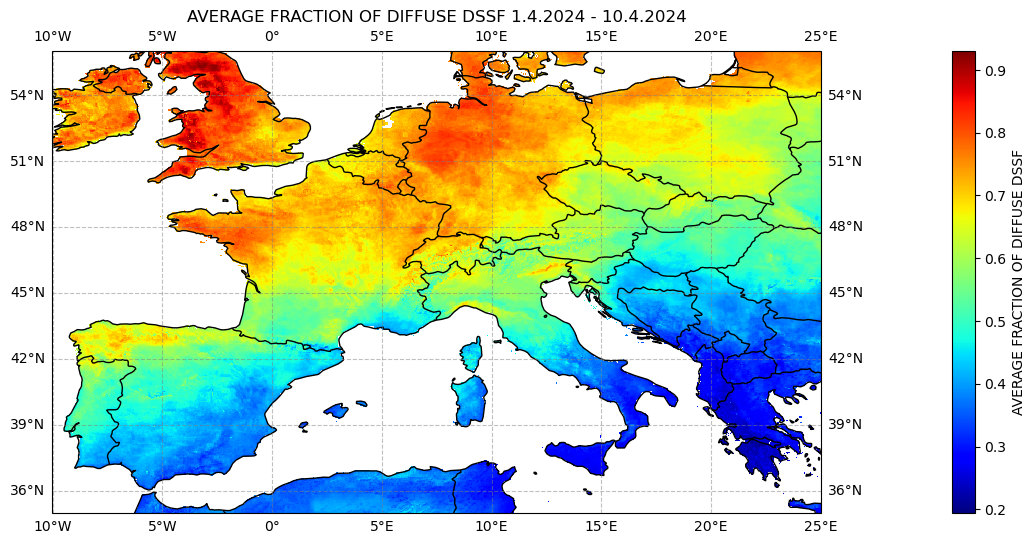

In [9]:
plot_data(
    average_fraction_diffuse_ds,
    title="AVERAGE FRACTION OF DIFFUSE DSSF 1.4.2024 - 10.4.2024",
    cmap_label="AVERAGE FRACTION OF DIFFUSE DSSF",
    cmap="jet"
)

# <a id='Fourth'></a>4. Determining the Sky Conditions from the LSA SAF MDSSFTD Product Quality Flag

We want to demonstrate the connection between cloud coverage and average total DSSF. In order to do so, we need to determine the cloud conditions at the time of the MDSSFTD total flux estimation. The cloud conditions are incorporated in the MSSSFTD product quality flag.

The different algorithms are used to estimate MSDDFTD values on clear and cloudy pixels. Furthermore, values are not estimated when the quality of measurements is too low. All the info about the algorithm and estimate quality are saved in the `NetCDF4` file quality flag variable, estimated for each pixel.

The quality flag is an 8-bit value, in which the first 2 bits represent the land/sea mask, the next 3 bits the cloud mask, and the remaining bits the algorithm used and the data quality. We can investigate all values of the quality flag that are represented in the selected dataset using the following code cell. We first extract all values from the dataset to the `numpy` array and then use `numpy.unique()` to identify all unique entries. 

In [10]:
# Define the quality flag dataset
quality_flag_ds=mdssft_ds.quality_flag

# Reduce the number of dimensions
flattened_values = quality_flag_ds.values.flatten()

# Get unique values
unique_values = np.unique(flattened_values)

# Print unique values
print(unique_values)

[  0.   9.  11.  13.  15.  37.  39.  73.  75.  77.  79. 133. 135. 145.
 147. 165. 167. 169. 171. 173. 175.]


Now we will proceed with counting the desired quality flag instances over the time dimension. With this approach we will also count the number of quality flags over the water pixels (oceans and land waters). Since the LSA SAF products are not evaluated ower the waters the count will equal to 0, but NaN values are desired, to distinguish areas without apperance of particular quality flag and water pixels.

We can avoid this problem by masking and using only the areas, where the LSA SAF MDSSFTD product is actually evaluated. The land/water mask is avaliable as an auxilliary `NetCDF4` file on the [LSA SAF Data Server](https://lsa-saf.eumetsat.int/en/user-support/auxiliary-data/). We first open and slice the land/water mask file content as an dataset.

In [11]:
# Open land/water mask
test_df=xr.open_dataset('Data_auxil/NETCDF_LSASAF_USGS-IGBP_LWMASK_MSG-Disk_202001270900.nc')

# Slice mask to the desired area
test_df=test_df.sel(lat=lat, lon=lon)

# Invvestigate the dataset
print(test_df)

<xarray.Dataset> Size: 2MB
Dimensions:  (time: 1, lat: 421, lon: 701)
Coordinates:
  * lat      (lat) float32 2kB 56.0 55.95 55.9 55.85 ... 35.15 35.1 35.05 35.0
  * lon      (lon) float32 3kB -10.0 -9.95 -9.9 -9.85 ... 24.85 24.9 24.95 25.0
  * time     (time) datetime64[ns] 8B 2020-01-27T09:00:00
Data variables:
    LWMASK   (time, lat, lon) float64 2MB ...
    crs      |S1 1B ...
Attributes: (12/27)
    date_created:               2021-01-28T11:26:47Z
    algorithm_version:          1.3.4
    base_algorithm_version:     4.8.1
    processing_level:           15
    platform:                   MSG4
    sensor:                     SEVI
    ...                         ...
    westernmost_longitude:      80.0
    spatial_resolution:          0.05x 0.05
    geospatial_lat_units:       degrees_north
    geospatial_lon_units:       degrees_east
    Conventions:                CF-1.6
    netcdf_version_id:          netCDF4


There are 3 possible values of the `LWMASK`variable: 0, corresponding to ocean, 1 corresponding to land and 3, corresponding to the inland waters. We want to construct a mask, that identifies both kinds of water pixels using the following code cell. The resulting mask is 3D, since the land/water mask `NetCDF4` file consists of the 3D array, with only 1 entry in the time dimension. Since the 2D mask is required the `.isel(time=0)` is used to effectively reduce the number of dimensions. 

Text(0.5, 1.0, 'Land/water mask')

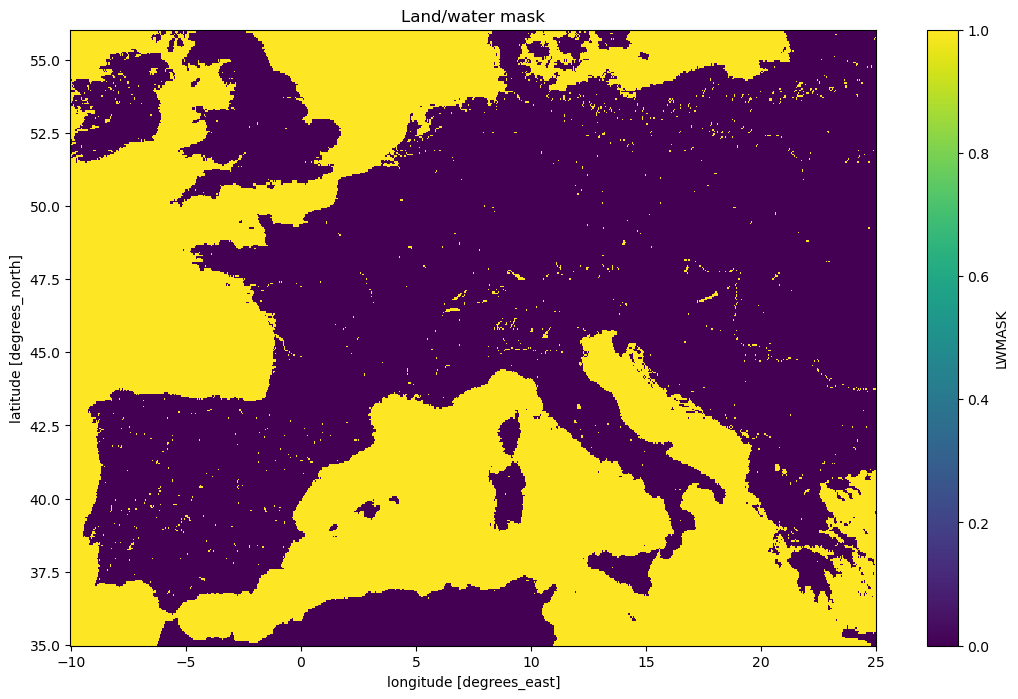

In [12]:
# Construct a mask 
mask = (test_df.LWMASK == 3) | (test_df.LWMASK == 0)

# Reduce mask from 3D to 2D
mask=mask.isel(time=0)

# Define mask plot
fig, ax = plt.subplots()

# Plot the data
img = mask.plot.pcolormesh(ax=ax)

# Set title
ax.set_title('Land/water mask')

A detailed description of the meaning of quality flags is available in the [MDSSFTD Product User Manual](https://nextcloud.lsasvcs.ipma.pt/s/bA9gYoa5mQX2yJw). In our analysis we will focus only on the instances with successfully processed day-time measurements representing the clear, cloudy and partially cloudy conditions, which corresponds to decimal values of the quality flag:

 * 133: Clear
 * 13: Cloudy
 * 9: Partially cloudy

We will begin by examining the instances with clear sky. Our goal is to illustrate the findings as the average number of hours with clear sky per day during the observed period (the first decade of April 2024). To determine this average, we will determine the number of estimates marked with a specific quality flag.

Given that estimates are provided every 15 minutes, we can calculate the number of hours with clear skies by dividing the total number of instances marked with the desired quality flag by 4. To obtain the average number of clear sky hours per day, we must further divide this result by the length of the time interval in days, which was calculated at the begining of this JN and saved in the `timedelta_days` variable.

It's important to note that the quality flag values of interest are not available during night-time. Therefore, the maximum possible number of clear sky hours per day is approximately 12 hours and not 24, depending on the local length of the day.

To determine a number of particular quality flags, we first create a mask with `True` (1) or `False` (0) values and sum them, which results in a number of instances with the desired quality flag. We create a mask using the `xarray` `.isin()` method, with the notation `(dataset == desired value)`. A detailed description of the approach is available [here](https://docs.xarray.dev/en/stable/generated/xarray.where.html).

After the summation, we want to filter only the land pixels. We do that by applying mask. We are applying the condition, that the mask identifying the water pixels is `False` using `.where(mask!=1)`.

In [13]:
# Apply mask and calculate fraction
quality_flag_clear=(quality_flag_ds == 133).sum(dim='time')/(4.0*timedelta_days)

# Apply land-water mask
quality_flag_clear=quality_flag_clear.where(mask != 1)

In the next step, we plot the results in the same manner as in previous sections with the help op `plot_data()`. To better differentiate plots from each other, different colormpas are used.

True

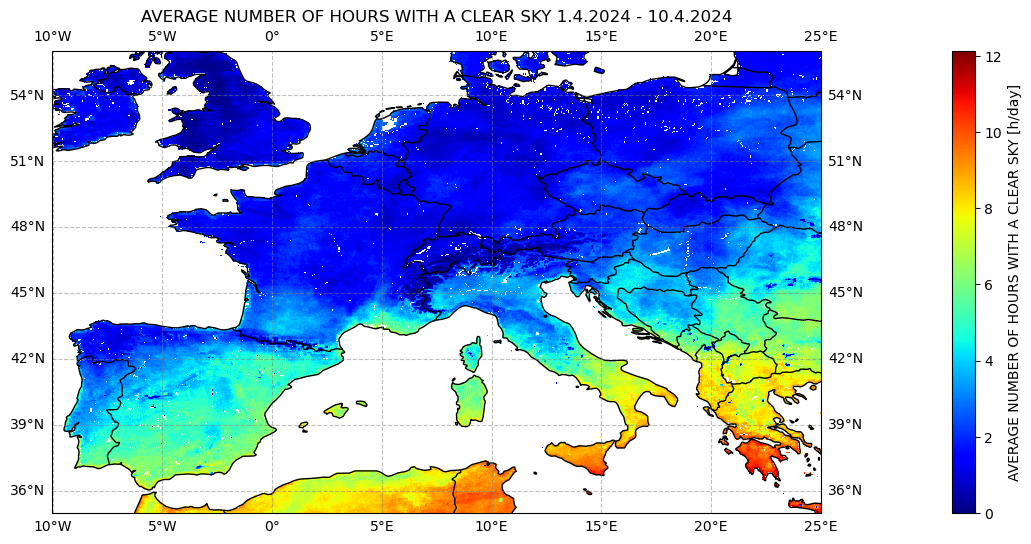

In [14]:
plot_data(
    quality_flag_clear,
    title="AVERAGE NUMBER OF HOURS WITH A CLEAR SKY 1.4.2024 - 10.4.2024",
    cmap_label="AVERAGE NUMBER OF HOURS WITH A CLEAR SKY [h/day]",
    cmap="jet"
)

Investigation of the cloud condition aims to demonstrate relation with the total DSSF. The idea is, that clouds will reduce the total DSSF. Since we are looking at only 10 days of data, our conclusions strongly depend on the weather conditions. If we compare the number of hours with a clear sky plot with the average total DSSF we can observe, that the regions with the highest average DSSF correlate with the areas, that exhibit a lot of clear sky per day. The areas with the most clear sky are in the mediterranean region.

The cloudy conditions are analyzed in the same way, by creating a boolean mask and summing it. In this case, we are investigating the value of quality flag 13.

In [15]:
# Apply mask and calculate fraction
quality_flag_cloudy=(quality_flag_ds == 13).sum(dim='time')/(4.0*timedelta_days)

# Apply land-water mask
quality_flag_cloudy=quality_flag_cloudy.where(mask != 1)

The plotting is executed in the same manner as for the clear sky example using `plot_data()`.

True

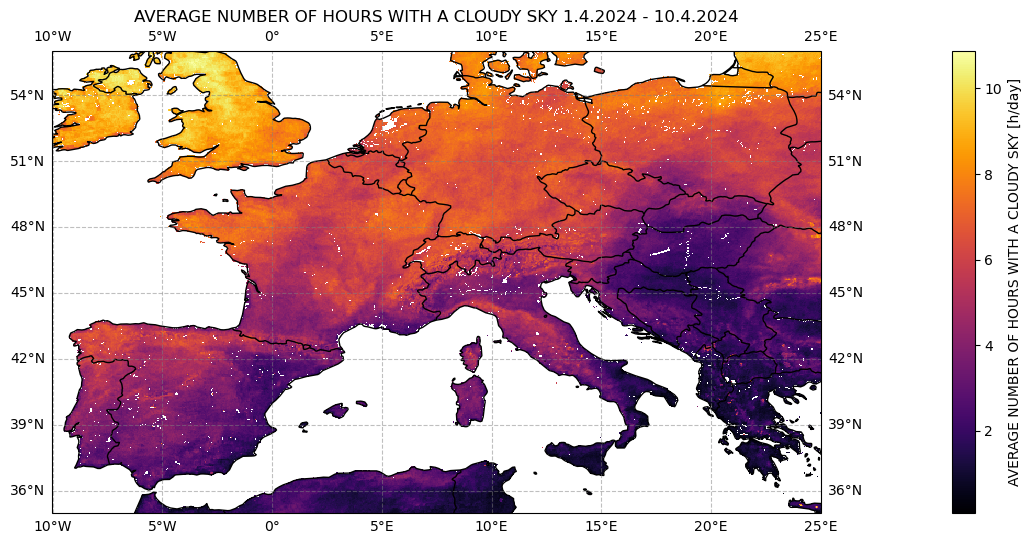

In [16]:
plot_data(
    quality_flag_cloudy,
    title="AVERAGE NUMBER OF HOURS WITH A CLOUDY SKY 1.4.2024 - 10.4.2024",
    cmap_label="AVERAGE NUMBER OF HOURS WITH A CLOUDY SKY [h/day]",
    cmap="inferno"
)

This plot indicates areas, where the sky was determined to be often completely cloudy in the observed period. Bear in mind, that due to the relatively short interval of observation, these areas are not necessarily the properties of the local climate, but rather the state of local weather in early April 2024. Areas with a lot of cloudy hours in the observed period were the British Isles as well as the southern and the central Germany, which also exhibited low values of total DSSF.

Last but not least we look at the instances with the partially cloudy sky, which corresponds to the value of quality flag 9. The approach is exactly the same as in the previous two examples.

In [17]:
# Apply mask and calculate fraction
quality_flag_partialy_cloudy=(quality_flag_ds == 9).sum(dim='time')/(4.0*timedelta_days)

# Apply land-water mask
quality_flag_partialy_cloudy=quality_flag_partialy_cloudy.where(mask != 1)

The approach used for the data visualization is also made in the same manner as before, using `plot_data()`.

True

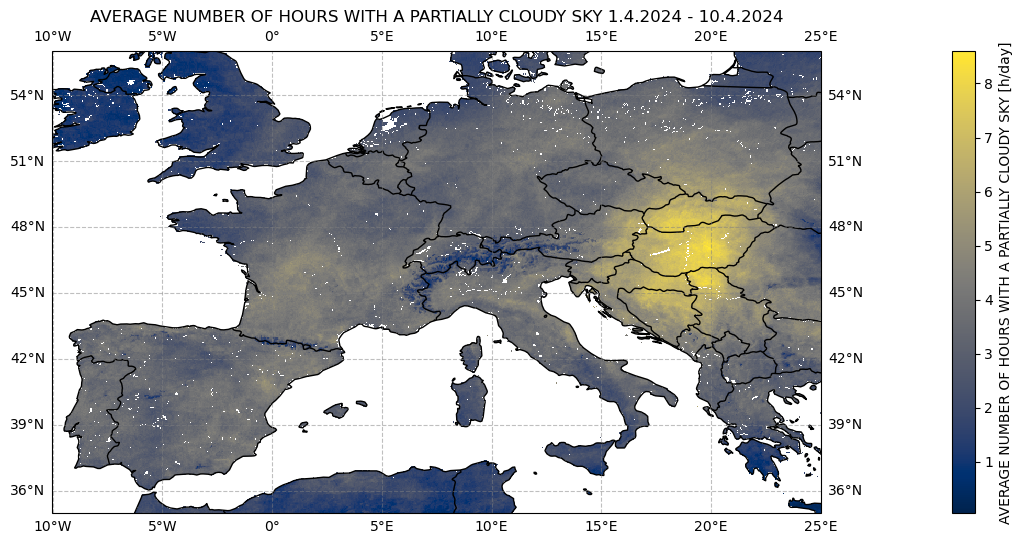

In [18]:
plot_data(
    quality_flag_partialy_cloudy,
    title="AVERAGE NUMBER OF HOURS WITH A PARTIALLY CLOUDY SKY 1.4.2024 - 10.4.2024",
    cmap_label="AVERAGE NUMBER OF HOURS WITH A PARTIALLY CLOUDY SKY [h/day]",
    cmap="cividis"
)

Last but not least, we investigated the partially cloudy quality flag. It can be observed that there are no major variations in the average number of hours with a partially cloudy sky, with the exception of the Great Hungarian Plain.

#### Conclusion

In this JN we plotted the average total DSSF as well as the fraction of the diffuse radiation. We compared results with the cloudiness in the analyzed interval and drew some connection between the higher cloud cover and smaller values of DSSF and with clear sky and higher values of DSSF. This was particularly clearly visible in the Mediterranean region, which had a lot of clear sky and relatively high values of average DSSF.

#### References:

* array Developers (2023). xarray User Guide. [https://docs.xarray.dev/en/stable/user-guide/index.html](https://docs.xarray.dev/en/stable/user-guide/index.html). Accesed: 31.5.2024

